In [2]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import pyorb

%matplotlib inline

#### 1. Read in Dataset and filter asteroids
> Filter asteroids which have a perihelia between 17 and 30, to adhere with paper

In [11]:
Centaurs = pd.read_csv("Data/Centaurs.csv")

#filter q on between 17 - 30 AU 
Centaurs = Centaurs[ (Centaurs['q'] < 30) & (Centaurs['q'] > 17)].reset_index(drop=True)

#drop q column, not necessary anymore, and set an ID for the objects
Centaurs.drop('q', axis=1, inplace=True)
Centaurs.reset_index(names='cloneOf', inplace=True)
Centaurs.head

<bound method NDFrame.head of     cloneOf          a         e          i           w          om  \
0         0  24.966699  0.244817   4.140735    5.497095  178.271004   
1         1  20.070776  0.132211   9.344995  154.679881  126.864296   
2         2  25.967409  0.237472   4.357911  266.777400   14.667089   
3         3  23.013043  0.217501  15.042869  155.559670  107.294178   
4         4  24.661483  0.042406  12.256986  178.410872  162.500755   
..      ...        ...       ...        ...         ...         ...   
60       60  25.091623  0.300902   4.291437   65.060013   79.342736   
61       61  28.969840  0.249141  29.544723  177.094133  165.672720   
62       62  23.634748  0.276392  27.022045   76.313856  276.811952   
63       63  28.070077  0.279005  21.119211  357.826375   96.546356   
64       64  18.020758  0.008990  11.909417  302.218609  308.419647   

            ma  
0    85.485989  
1   127.767199  
2    19.801745  
3    16.797701  
4    90.602241  
..         ... 

In [12]:
#Convert the mean anomaly to true anomaly
Centaurs[['i', 'om', 'w', 'ma']] = np.radians(Centaurs[['i', 'om', 'w', 'ma']])
Centaurs['a'] = Centaurs['a'] * 1.495978707e8
Centaurs.head

<bound method NDFrame.head of     cloneOf             a         e         i         w        om        ma
0         0  3.734965e+09  0.244817  0.072269  0.095942  3.111416  1.492012
1         1  3.002545e+09  0.132211  0.163101  2.699673  2.214200  2.229958
2         2  3.884669e+09  0.237472  0.076060  4.656144  0.255989  0.345606
3         3  3.442702e+09  0.217501  0.262548  2.715028  1.872637  0.293175
4         4  3.689305e+09  0.042406  0.213925  3.113857  2.836173  1.581307
..      ...           ...       ...       ...       ...       ...       ...
60       60  3.753653e+09  0.300902  0.074900  1.135511  1.384792  0.376349
61       61  4.333826e+09  0.249141  0.515653  3.090876  2.891534  3.045770
62       62  3.535708e+09  0.276392  0.471624  1.331928  4.831280  1.925115
63       63  4.199224e+09  0.279005  0.368600  6.245248  1.685052  0.589635
64       64  2.695867e+09  0.008990  0.207859  5.274710  5.382938  1.820122

[65 rows x 7 columns]>

In [13]:
Centaurs['E'] = pyorb.kepler.mean_to_eccentric(np.array(Centaurs['ma']), np.array(Centaurs['e']))
Centaurs['ta'] = 2 * np.arctan(np.sqrt((1 + Centaurs['e'])/(1 - Centaurs['e'])) * np.tan(Centaurs['E'] / 2))
Centaurs.drop(['E', 'ma'], axis=1, inplace=True)
Centaurs.head

<bound method NDFrame.head of     cloneOf             a         e         i         w        om        ta
0         0  3.734965e+09  0.244817  0.072269  0.095942  3.111416  1.972911
1         1  3.002545e+09  0.132211  0.163101  2.699673  2.214200  2.418605
2         2  3.884669e+09  0.237472  0.076060  4.656144  0.255989  0.565673
3         3  3.442702e+09  0.217501  0.262548  2.715028  1.872637  0.461454
4         4  3.689305e+09  0.042406  0.213925  3.113857  2.836173  1.665966
..      ...           ...       ...       ...       ...       ...       ...
60       60  3.753653e+09  0.300902  0.074900  1.135511  1.384792  0.706438
61       61  4.333826e+09  0.249141  0.515653  3.090876  2.891534  3.082095
62       62  3.535708e+09  0.276392  0.471624  1.331928  4.831280  2.372797
63       63  4.199224e+09  0.279005  0.368600  6.245248  1.685052  1.010547
64       64  2.695867e+09  0.008990  0.207859  5.274710  5.382938  1.837498

[65 rows x 7 columns]>

#### 2. Create grid for cloning Centaur objects
> A 5x5x5x3 grid will be used (not same as paper to reduce amount asteroids, but the same range) to clone the objects in $\alpha, e, i, w$. The seperations of this grid are as follows:
> - 0.15 AU in semi-major axis (a)
> - 0.075 in eccentricity (e)
> - 0.75 degrees in inclination (i)
> - 5 degrees in argument of perihelion (w)

In [14]:
a_increment = np.array([-0.3, -0.15, 0, 0.15, 0.3]) * 1.495978707e8  # Convert AU to km
e_increment = [-0.15, -0.075, 0, 0.075, 0.15]
i_increment = np.radians([-1.5, -0.75, 0, 0.75, 1.5])
w_increment = np.radians([-5, 0, 5])

grid_array = np.array(list(product(a_increment, e_increment, i_increment, w_increment)))

# remove the original object (where all are 0)
grid_array = grid_array[~np.all(grid_array == 0, axis=1)]
print(grid_array)

[[-4.48793612e+07 -1.50000000e-01 -2.61799388e-02 -8.72664626e-02]
 [-4.48793612e+07 -1.50000000e-01 -2.61799388e-02  0.00000000e+00]
 [-4.48793612e+07 -1.50000000e-01 -2.61799388e-02  8.72664626e-02]
 ...
 [ 4.48793612e+07  1.50000000e-01  2.61799388e-02 -8.72664626e-02]
 [ 4.48793612e+07  1.50000000e-01  2.61799388e-02  0.00000000e+00]
 [ 4.48793612e+07  1.50000000e-01  2.61799388e-02  8.72664626e-02]]


In [15]:
#add other two columns to easily clone the real Centaurs using matrix transofmations
grid_array_padded = np.concatenate([np.full((grid_array.shape[0], 1), 1000), grid_array, np.zeros((grid_array.shape[0], 2))], axis=1)
grid_array_padded

array([[ 1.00000000e+03, -4.48793612e+07, -1.50000000e-01, ...,
        -8.72664626e-02,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+03, -4.48793612e+07, -1.50000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+03, -4.48793612e+07, -1.50000000e-01, ...,
         8.72664626e-02,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.00000000e+03,  4.48793612e+07,  1.50000000e-01, ...,
        -8.72664626e-02,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+03,  4.48793612e+07,  1.50000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+03,  4.48793612e+07,  1.50000000e-01, ...,
         8.72664626e-02,  0.00000000e+00,  0.00000000e+00]],
      shape=(374, 7))

In [16]:
#testing if cloning works for individual Centaurs
grid_array_padded + Centaurs.iloc[4].values 

array([[ 1.00400000e+03,  3.64442603e+09, -1.07594011e-01, ...,
         3.02659067e+00,  2.83617320e+00,  1.66596626e+00],
       [ 1.00400000e+03,  3.64442603e+09, -1.07594011e-01, ...,
         3.11385714e+00,  2.83617320e+00,  1.66596626e+00],
       [ 1.00400000e+03,  3.64442603e+09, -1.07594011e-01, ...,
         3.20112360e+00,  2.83617320e+00,  1.66596626e+00],
       ...,
       [ 1.00400000e+03,  3.73418476e+09,  1.92405989e-01, ...,
         3.02659067e+00,  2.83617320e+00,  1.66596626e+00],
       [ 1.00400000e+03,  3.73418476e+09,  1.92405989e-01, ...,
         3.11385714e+00,  2.83617320e+00,  1.66596626e+00],
       [ 1.00400000e+03,  3.73418476e+09,  1.92405989e-01, ...,
         3.20112360e+00,  2.83617320e+00,  1.66596626e+00]],
      shape=(374, 7))

In [17]:
#creating dataframe with the original and clones of Centaur objects
#clones can be denoted by the cloneOf column, where a clone is 1000 above
#the original object.
new_asteroids = Centaurs.values
for row in Centaurs.values:
    new_asteroids =  np.concatenate([new_asteroids, (grid_array_padded + row)], axis=0)

new_asteroids.shape
cloned_centaurs = pd.DataFrame(new_asteroids, columns=['cloneOf', 'a', 'e', 'i', 'w', 'om', 'ta'])
cloned_centaurs['e'] = cloned_centaurs['e'].clip(0, 1) #make sure e is between 0 and 1
cloned_centaurs.head

<bound method NDFrame.head of        cloneOf             a         e         i         w        om        ta
0          0.0  3.734965e+09  0.244817  0.072269  0.095942  3.111416  1.972911
1          1.0  3.002545e+09  0.132211  0.163101  2.699673  2.214200  2.418605
2          2.0  3.884669e+09  0.237472  0.076060  4.656144  0.255989  0.565673
3          3.0  3.442702e+09  0.217501  0.262548  2.715028  1.872637  0.461454
4          4.0  3.689305e+09  0.042406  0.213925  3.113857  2.836173  1.665966
...        ...           ...       ...       ...       ...       ...       ...
24370   1064.0  2.740746e+09  0.158990  0.220949  5.274710  5.382938  1.837498
24371   1064.0  2.740746e+09  0.158990  0.220949  5.361976  5.382938  1.837498
24372   1064.0  2.740746e+09  0.158990  0.234038  5.187443  5.382938  1.837498
24373   1064.0  2.740746e+09  0.158990  0.234038  5.274710  5.382938  1.837498
24374   1064.0  2.740746e+09  0.158990  0.234038  5.361976  5.382938  1.837498

[24375 rows x 7 colum

In [18]:
def kep_to_cart(DF):
    """Function that will convert the kepler orbital elements into x,y,z,Vx,Vy,Vz values for the Centaur objects
    The units expected are km, days and radians. It also asumes that the object will be orbiting the sun, hence the
    gravitiational parameter 9.90693e20. The output will be stored in Data/centaurData.csv"""
    Centaurs_cartesian = []
    for i in range(DF.shape[0]):
        cartesian = pyorb.kep_to_cart(DF.iloc[i].values[1:], mu=9.90693e20, degrees=False)
        Centaurs_cartesian.append(np.append(cartesian, DF.iloc[i].values[0]))
    
    Centaurs_cartesian = pd.DataFrame(Centaurs_cartesian, columns=['x','y','z','Vx','Vy','Vz','cloneOf'])
    Centaurs_cartesian[['cloneOf']]=  Centaurs_cartesian[['cloneOf']].apply(lambda x: x.astype(int)) #convert cloneOf to int
    Centaurs_cartesian.to_csv("Data/centaurData.csv")

#Uncomment this to generate the dataset
kep_to_cart(cloned_centaurs)

In [11]:
centaurs = pd.read_csv("Data/centaurData.csv", index_col=0)
centaurs[['x', 'y', 'z']] = centaurs[['x', 'y', 'z']] / 1.495978707e8
centaurs

,x,y,z,Vx,Vy,Vz,cloneOf
0,11.708454,-23.108125,1.646589,482634.714134,109476.217840,-8976.213838,0
1,10.691741,18.820090,-3.265682,-425707.524011,305301.553849,25907.760646,1
2,14.128471,-14.668412,-1.354028,496058.100873,383993.415192,18737.550600,2
3,6.042139,-17.326529,-0.166139,615807.239281,160013.388965,-170801.018501,3
4,5.657816,23.483977,-5.235358,-496766.084044,143339.984451,2752.080141,4
...,...,...,...,...,...,...,...
24370,18.329659,-1.533994,3.011574,125861.949489,568330.556858,101476.897296,1064
24371,18.354610,0.075610,3.240633,75849.413184,578389.407392,94079.608887,1064
24372,18.136083,-3.155025,2.920175,173775.663303,553041.434859,114392.320739,1064
24373,18.297874,-1.559205,3.186817,124790.934379,567481.082601,107381.825553,1064


In [21]:
celestials = pd.read_csv("Data/celestialData.csv", index_col=0)
celestials[['x', 'y', 'z', 'radius']] = celestials[['x', 'y', 'z', 'radius']] / 1.495978707e8
celestials

,x,y,z,vx,vy,vz,mass,radius
name,,,,,,,,
Sun,-0.005731,-0.004911,0.000180,1.071239e+03,-548.507515,17.607253,1.988410e+30,0.004650
Earth,-0.184414,0.962072,0.000128,-2.572721e+06,-478294.272645,-16.790872,5.970000e+24,0.000043
Mars,-0.527416,1.520324,0.044935,-1.900592e+06,-500031.800248,36151.989037,6.420000e+23,0.000023
Jupiter,1.050303,4.966542,-0.044099,-1.117363e+06,287347.519551,23806.980598,1.898000e+27,0.000478
Saturn,9.455337,-1.769525,-0.345697,1.071931e+05,818514.425824,-18453.240561,5.680000e+26,0.000403
Uranus,11.097905,16.089576,-0.084019,-4.886707e+05,306654.964826,7475.345445,8.680000e+25,0.000170
Neptune,29.874197,-0.639099,-0.675320,6.967781e+03,472239.073516,-9946.412804,1.020000e+26,0.000165


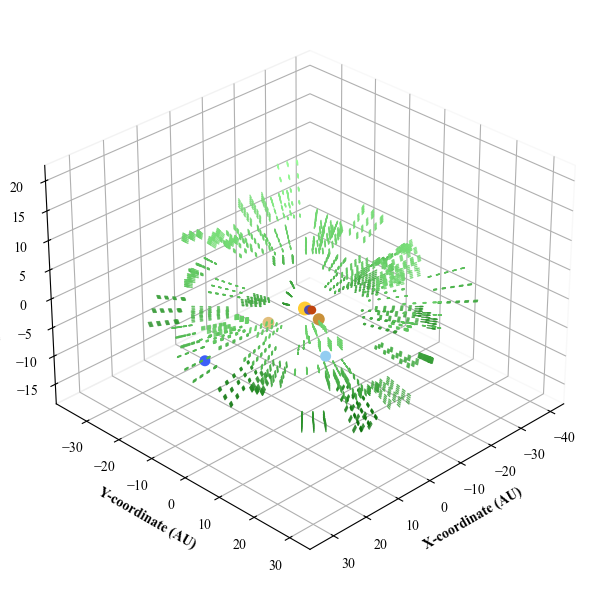

In [47]:
def plotSolarSystem(centaurs, celestials):
    fig = plt.figure(figsize=(7, 6))

    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['mathtext.rm'] = 'Times New Roman'
    plt.rcParams['font.family'] ='Times New Roman'

    ax = fig.add_subplot(111, projection='3d')  # Single subplot

    # Custom color map
    import matplotlib.colors as mcolors
    green_colors = [(0.0, 0.4, 0.0), (0.4, 0.8, 0.4), (0.6, 1.0, 0.6)] 
    custom_green_cmap = mcolors.LinearSegmentedColormap.from_list("CustomGreen", green_colors)
    
    # Plot settings
    plot_args_centaurs = {
        'c': centaurs['z'],
        'cmap': custom_green_cmap,
        'alpha': 0.7,
        's': 1,
        'edgecolors': 'none'
    }
    
    plot_args_celestials = {
        'c': ["#ffcc33", "#4f4cb0", "#c1440e", "#c99039", "#e2bf7d", "#93cdf1", "#3d5ef9"],
        'alpha': 1,
        's': [100, 47.110485, 40, 74.100869, 72.041347, 62.676178, 62.342535],
        'edgecolors': 'none'
    }

    # Plot Centaurs
    ax.scatter(centaurs['x'], centaurs['y'], centaurs['z'], **plot_args_centaurs)

    # Plot Celestials
    ax.scatter(celestials['x'], celestials['y'], celestials['z'], **plot_args_celestials)

    # Axis labels and styling
    ax.set_xlabel('X-coordinate (AU)', fontweight='bold')
    ax.set_ylabel('Y-coordinate (AU)', fontweight='bold')
    ax.set_zlabel('Z-coordinate (AU)', fontweight='bold')
    ax.grid(True, linestyle='--', linewidth=1, alpha=1, c="w")
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    plt.tight_layout()
    ax.view_init(elev=30, azim=45)
    return fig, ax

fig, ax = plotSolarSystem(centaurs, celestials)
plt.savefig("Figures/initialSolarSystem.png", dpi=1000)
plt.show()

In [34]:
centaurFirstClones = centaurs[(centaurs['cloneOf'] == 0) | (centaurs['cloneOf'] == 1000)]
centaurFirstClones

,x,y,z,Vx,Vy,Vz,cloneOf
0,11.708454,-23.108125,1.646589,482634.714134,109476.217840,-8976.213838,0
65,9.431781,-23.545518,1.072351,482175.883092,143849.073801,-7302.611463,1000
66,11.450143,-22.634890,1.027561,467787.788559,185282.339487,-9192.711941,1000
67,13.381361,-21.551996,0.974951,449839.546496,225305.494693,-11012.850330,1000
68,9.432265,-23.529497,1.376595,482172.589720,143739.970593,-9374.485564,1000
...,...,...,...,...,...,...,...
434,11.379240,-22.434191,1.889382,511790.861937,31607.973309,-4024.693733,1000
435,13.298121,-21.361090,1.792648,507068.664820,75931.706002,-7803.440259,1000
436,9.374594,-23.308783,2.273193,512617.930025,-12959.347756,-248.236327,1000
437,11.380043,-22.407580,2.178247,511789.150839,31551.287880,-4640.023100,1000


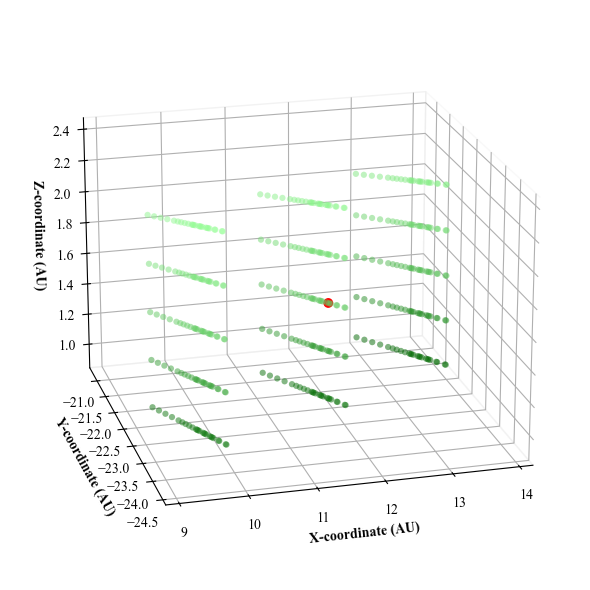

In [48]:
def plotSingleAngle3D(centaurs):
    fig = plt.figure(figsize=(8, 6))

    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['mathtext.rm'] = 'Times New Roman'
    plt.rcParams['font.family'] ='Times New Roman'
    
    # Create only the top-right subplot
    ax = fig.add_subplot(111, projection='3d')  # Single subplot

    # Custom color map
    import matplotlib.colors as mcolors
    green_colors = [(0.0, 0.4, 0.0), (0.4, 0.8, 0.4), (0.6, 1.0, 0.6)] 
    custom_green_cmap = mcolors.LinearSegmentedColormap.from_list("CustomGreen", green_colors)

    # Plot settings
    plot_args_original = {
        'c': 'red',
        'alpha': 1,
        's': 50,
        'edgecolors': 'none'
    }
    
    plot_args_clones = {
        'c': centaurs[1:]['z'],
        'cmap': custom_green_cmap,
        'alpha': 0.5,
        's': 20,
        'edgecolors': 'none'
    }

    # Plot data
    ax.scatter(centaurs[:1]['x'], centaurs[:1]['y'], centaurs[:1]['z'], **plot_args_original)
    ax.scatter(centaurs[1:]['x'], centaurs[1:]['y'], centaurs[1:]['z'], **plot_args_clones)
    
    # Axis labels and styling
    ax.set_xlabel('X-coordinate (AU)', fontweight='bold')
    ax.set_ylabel('Y-coordinate (AU)', fontweight='bold')
    ax.set_zlabel('Z-coordinate (AU)', fontweight='bold')
    ax.grid(True, linestyle='--', linewidth=1, alpha=1, c="w")
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Set specific view angle (original ax2 settings)
    ax.view_init(elev=20, azim=255)

    plt.tight_layout()
    return fig, ax

# Usage
fig, ax = plotSingleAngle3D(centaurFirstClones)
plt.savefig("Figures/singularClonesFigure.png", dpi=1000)
plt.show()